In [54]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso, lars_path
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from scipy.stats import norm
import os

# Define transformation and inverse transformation functions
def asinh_transform(x, median_val, mad_val, c=0.6745):
    """
    Apply the area hyperbolic sine (asinh) transformation.
    Steps:
    1. Standardize the data using (X - median) / (MAD/c).
    2. Apply asinh(X) = log(X + sqrt(X^2 + 1)).
    """
    x_std = (x - median_val) / (mad_val / c)
    return np.log(x_std + np.sqrt(x_std**2 + 1))

def asinh_inverse_transform(x_asinh, median_val, mad_val, c=0.6745):
    # Clip values to prevent overflow
    x_asinh_clipped = np.clip(x_asinh, -20, 20)  # adjust clipping range if needed
    x_std = np.sinh(x_asinh_clipped)
    return x_std * (mad_val / c) + median_val

df = pd.read_csv("big data matrix.csv", parse_dates=["Date"])
df.set_index("Date", inplace=True)
df.sort_index(inplace=True)

price_col = "Price"
day_dummies = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
excluded_cols = [price_col] + day_dummies
x_cols = [col for col in df.columns if col not in excluded_cols]

# Check frequency
freq = (df.index[1] - df.index[0])
if freq != timedelta(hours=1):
    raise ValueError("Data frequency is not hourly.")

# Compute median and MAD
median_price = df[price_col].median()
mad_price = (df[price_col] - median_price).abs().median()

# Transform prices
df["Price_asinh"] = asinh_transform(df[price_col], median_price, mad_price)

# Extract unique days
unique_days = pd.Series(df.index.date).unique()

# Decide on start_day and end_day
start_day = unique_days[7]  # after first 7 days
end_day = unique_days[-1]

print("Data preprocessing done.")
print("Number of unique days:", len(unique_days))

Data preprocessing done.
Number of unique days: 628


In [55]:
def get_day_vectors(day, df, price_col="Price_asinh", x_cols=None):
    if x_cols is None:
        raise ValueError("x_cols must be provided.")
    day_mask = df.index.normalize() == pd.to_datetime(day)
    day_data = df.loc[day_mask]
    # print(f"Day {day}: Found {len(day_data)} hours")
    if len(day_data) < 24:
        # print(f"Day {day} is incomplete (less than 24 hours)")
        return None, None
    p_vector = day_data[price_col].values  # asinh scale prices
    x_matrix = day_data[x_cols].values
    return p_vector, x_matrix

def construct_features(d, h, df, price_col="Price_asinh", x_cols=None, day_dummies=None):
    """
    Construct the feature vector for a given day (d) and hour (h).
    
    Parameters:
    ----------
    d : str or datetime-like
        The day for which features are being constructed.
    h : int
        The hour of the day (0-23) for which features are being constructed.
    df : pd.DataFrame
        The DataFrame containing the data.
    price_col : str
        The column name for prices (default: "Price_asinh").
    x_cols : list
        The column names for exogenous variables.
    day_dummies : list
        The column names for day-of-week dummies.
    
    Returns:
    -------
    np.ndarray or None
        The feature vector for the given day and hour, or None if data is incomplete.
    """
    if x_cols is None or day_dummies is None:
        raise ValueError("x_cols and day_dummies must be provided.")
    d_date = pd.to_datetime(d).date()

    # Define required days
    required_days = [
        d_date - pd.Timedelta(days=1),  # d-1
        d_date - pd.Timedelta(days=2),  # d-2
        d_date - pd.Timedelta(days=3),  # d-3
        d_date - pd.Timedelta(days=7),  # d-7
        d_date,                         # d (current day for x_d)
        d_date - pd.Timedelta(days=1),  # d-1 (for x_{d-1})
        d_date - pd.Timedelta(days=7)   # d-7 (for x_{d-7})
    ]

    # print("Constructing features for", d, "hour", h)
    # print("Required days:", required_days)

    # Initialize storage for vectors
    day_vectors = {}
    day_x_vectors = {}

    # Retrieve data for each required day
    for day_req in required_days:
        p_vec, x_mat = get_day_vectors(day_req, df, price_col=price_col, x_cols=x_cols)
        # print(f"Day {day_req}:")
        if p_vec is None or x_mat is None:
            # print(f"  Missing or incomplete data for day {day_req}")
            return None
        else:
            # print(f"  Found {len(p_vec)} prices and {x_mat.shape} exogenous matrix")
            day_vectors[day_req] = p_vec
            day_x_vectors[day_req] = x_mat

    # Assemble price features
    # print("Assembling price features...")
    p_features = np.concatenate([
        day_vectors[d_date - pd.Timedelta(days=1)],
        day_vectors[d_date - pd.Timedelta(days=2)],
        day_vectors[d_date - pd.Timedelta(days=3)],
        day_vectors[d_date - pd.Timedelta(days=7)]
    ])
    # print(f"Price features shape: {p_features.shape}")

    # Assemble exogenous features
    # print("Assembling exogenous features...")
    x_features = np.concatenate([
        day_x_vectors[d_date],  # x_d
        day_x_vectors[d_date - pd.Timedelta(days=1)],  # x_{d-1}
        day_x_vectors[d_date - pd.Timedelta(days=7)]   # x_{d-7}
    ], axis=0).flatten()
    # print(f"Exogenous features shape: {x_features.shape}")

    # Add day-of-week dummies
    # print("Adding day-of-week dummies...")
    day_mask = df.index.date == d_date
    # print(f"Day mask for {d_date}: {day_mask.sum()} rows found")
    if day_mask.sum() < 24:
        # print(f"  Missing hours for day {d_date}")
        return None
    day_data = df.loc[day_mask].iloc[0]  # First row for dummies (same for all rows)
    z_features = day_data[day_dummies].values
    # print(f"Day-of-week dummies: {z_features}")

    # Final feature vector
    features = np.concatenate([p_features, x_features, z_features])
    # print(f"Final feature vector shape: {features.shape}")
    return features

from sklearn.linear_model import Lasso, lars_path
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
import warnings

def compute_aic(y_true, y_pred, num_params):
    """
    Computes the AIC = n*log(RSS/n) + 2*k
    where:
    - n is number of observations
    - RSS is residual sum of squares
    - k is num_params (the number of non-zero coefficients in LASSO)
    """
    n = len(y_true)
    rss = np.sum((y_true - y_pred)**2)
    if rss < 1e-15:
        rss = 1e-15
    return n * np.log(rss / n) + 2 * num_params

def find_best_alpha_lars_aic(X, y, fit_intercept=True):
    """
    Uses LARS to find a sequence of alphas and coefficients.
    Then computes the AIC for each alpha, returning the alpha that yields the lowest AIC.
    """
    # Standardize X
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    if fit_intercept:
        # Center y
        y_mean = y.mean()
        y_centered = y - y_mean
    else:
        y_centered = y
        y_mean = 0
    
    # Run LARS path
    # Note: we use fit_intercept=False here because we manually handle intercept with centering
    alphas, active, coefs = lars_path(X_scaled, y_centered, method='lasso', verbose=False)
    # coefs.shape = (n_features, n_alphas)
    
    best_alpha = None
    best_aic = np.inf
    
    for i, alpha in enumerate(alphas):
        beta = coefs[:, i]
        # Number of nonzero betas
        k = np.count_nonzero(beta)
        
        # Predict in scaled domain
        y_pred_centered = X_scaled @ beta
        # Estimate intercept by simple mean difference
        if fit_intercept:
            intercept = (y_centered - y_pred_centered).mean()
            y_pred = y_pred_centered + intercept + y_mean
        else:
            y_pred = y_pred_centered
        
        # AIC
        aic = compute_aic(y, y_pred, k)
        if aic < best_aic:
            best_aic = aic
            best_alpha = alpha

    return best_alpha


In [56]:
# Assume unique_days contains all unique days in the dataset
train_start = unique_days[7]  # Start training after the first 7 days
train_end = unique_days[364]   # Define your training end date
test_start = train_end + pd.Timedelta(days=1)  # Start forecasting the day after training ends

print(f"Training period: {train_start} to {train_end}")
print(f"Forecasting starts from: {test_start}")


Training period: 2023-01-08 to 2023-12-31
Forecasting starts from: 2024-01-01


In [62]:
import pandas as pd
import numpy as np
from tqdm import tqdm  # <-- We import tqdm here
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
import warnings

#############################
# 1) Define Key Parameters  #
#############################
calibration_window_days = 60  # The first 60 days of your test set for error calibration
hours_in_day = 24
rolling_window_days = 365     # Example: 1 year of data for rolling re-calibration (adjust as needed)

# We already have train_start, train_end, test_start from your snippet:
#   train_start = unique_days[7]
#   train_end   = unique_days[364]
#   test_start  = train_end + pd.Timedelta(days=1)

# Build lists of days
train_days = [day for day in unique_days if (day >= train_start and day <= train_end)]
test_days  = [day for day in unique_days if day >= test_start]

# We'll define a "calibration phase" = first 60 test days
# and a "distribution phase" = the remainder of the test days
if len(test_days) < calibration_window_days:
    raise ValueError("Not enough test days to have a 60-day calibration window.")
calibration_phase_days   = test_days[:calibration_window_days]
distribution_phase_days  = test_days[calibration_window_days:]

##################################
# 2) Storage for Forecasts, etc. #
##################################
daily_forecasts = {}  # daily_forecasts[day] = array of shape (24,) with day-ahead predictions
chosen_alphas   = {}  # chosen_alphas[(day, hour)] = alpha

###################
# 3) Lags Config  #
###################
# This dictionary specifies whether or not to include certain lags in the feature vector.
# Feel free to expand or reorganize as needed.
lags_config = {
    "use_price_dminus1": True,
    "use_price_dminus2": True,
    "use_price_dminus3": False,
    "use_price_dminus7": True,
    
    "use_exog_d": True,
    "use_exog_dminus1": True,
    "use_exog_dminus7": False,
    
    # ... potential toggles for day-of-week dummies, etc.
    "use_day_of_week_dummies": True,
}

####################################################
# 4) Modified construct_features to use lags_config #
####################################################
def construct_features_with_config(
    d,
    h,
    df,
    price_col="Price_asinh",
    x_cols=None,
    day_dummies=None,
    lags_config=None,
):
    """
    Construct the feature vector for a given day (d) and hour (h), 
    using the user-defined config to select/deselect certain lags.

    lags_config is a dict that toggles whether certain price or exogenous lags are included.
    """
    if x_cols is None or day_dummies is None:
        raise ValueError("x_cols and day_dummies must be provided.")

    if lags_config is None:
        # Default: All lags on
        lags_config = {
            "use_price_dminus1": True,
            "use_price_dminus2": True,
            "use_price_dminus3": True,
            "use_price_dminus7": True,
            "use_exog_d": True,
            "use_exog_dminus1": True,
            "use_exog_dminus7": True,
            "use_day_of_week_dummies": True,
        }
    
    d_date = pd.to_datetime(d).date()

    # We'll gather the relevant days for price lags
    required_price_days = []
    if lags_config["use_price_dminus1"]:
        required_price_days.append(d_date - pd.Timedelta(days=1))
    if lags_config["use_price_dminus2"]:
        required_price_days.append(d_date - pd.Timedelta(days=2))
    if lags_config["use_price_dminus3"]:
        required_price_days.append(d_date - pd.Timedelta(days=3))
    if lags_config["use_price_dminus7"]:
        required_price_days.append(d_date - pd.Timedelta(days=7))

    # We'll gather the relevant days for exogenous lags
    required_exog_days = []
    if lags_config["use_exog_d"]:
        required_exog_days.append(d_date)
    if lags_config["use_exog_dminus1"]:
        required_exog_days.append(d_date - pd.Timedelta(days=1))
    if lags_config["use_exog_dminus7"]:
        required_exog_days.append(d_date - pd.Timedelta(days=7))

    # Check we have enough data
    # Price-lag days + the day-of-week day for dummies
    unique_req_days = set(required_price_days + required_exog_days + [d_date])
    
    # We'll store day_vectors for price, day_x_vectors for exogs
    day_vectors = {}
    day_x_vectors = {}
    
    # Retrieve data for each needed day
    for day_req in unique_req_days:
        # Reuse your original get_day_vectors
        p_vec, x_mat = get_day_vectors(
            day_req, df, price_col=price_col, x_cols=x_cols
        )
        if p_vec is None or x_mat is None:
            return None  # incomplete
        day_vectors[day_req] = p_vec
        day_x_vectors[day_req] = x_mat

    # ~~~~~ Build price features ~~~~~
    price_features = []
    if lags_config["use_price_dminus1"]:
        price_features.append(day_vectors[d_date - pd.Timedelta(days=1)])
    if lags_config["use_price_dminus2"]:
        price_features.append(day_vectors[d_date - pd.Timedelta(days=2)])
    if lags_config["use_price_dminus3"]:
        price_features.append(day_vectors[d_date - pd.Timedelta(days=3)])
    if lags_config["use_price_dminus7"]:
        price_features.append(day_vectors[d_date - pd.Timedelta(days=7)])
    
    p_features = np.concatenate(price_features) if len(price_features) > 0 else np.array([])

    # ~~~~~ Build exogenous features ~~~~~
    exog_features = []
    if lags_config["use_exog_d"]:
        exog_features.append(day_x_vectors[d_date])
    if lags_config["use_exog_dminus1"]:
        exog_features.append(day_x_vectors[d_date - pd.Timedelta(days=1)])
    if lags_config["use_exog_dminus7"]:
        exog_features.append(day_x_vectors[d_date - pd.Timedelta(days=7)])
    
    if len(exog_features) > 0:
        x_features = np.concatenate(exog_features, axis=0).flatten()
    else:
        x_features = np.array([])

    # ~~~~~ Day-of-week dummies ~~~~~
    z_features = []
    if lags_config["use_day_of_week_dummies"]:
        day_mask = df.index.date == d_date
        if day_mask.sum() < 24:
            return None
        day_data = df.loc[day_mask].iloc[0]
        z_features = day_data[day_dummies].values
    else:
        z_features = np.array([])

    # Final feature vector
    features = np.concatenate([p_features, x_features, z_features])
    return features

In [63]:
#############################################
# 5) Build Rolling Data + Forecast Each Day #
#############################################
def build_rolling_train_data(current_day, rolling_days):
    """
    Gathers all days from (current_day - rolling_days) up to (current_day - 1),
    within the boundaries of your data, to build training features/targets.
    Returns:
        X_train_dict[h], y_train_dict[h]
    """
    current_date = pd.to_datetime(current_day)
    earliest_day = current_date - pd.Timedelta(days=rolling_days)
    
    possible_hist_days = [d for d in unique_days if (d >= earliest_day.date()) and (d < current_date.date())]
    
    X_train_dict = {h: [] for h in range(hours_in_day)}
    y_train_dict = {h: [] for h in range(hours_in_day)}

    for hist_day in possible_hist_days:
        for h in range(hours_in_day):
            feats = construct_features_with_config(
                hist_day,
                h,
                df,
                price_col="Price_asinh",
                x_cols=x_cols,
                day_dummies=day_dummies,
                lags_config=lags_config  # pass the toggles
            )
            if feats is None:
                continue
            day_mask = ((df.index.date == pd.to_datetime(hist_day).date()) & (df.index.hour == h))
            target_vals = df.loc[day_mask, "Price_asinh"].values
            if len(target_vals) == 0:
                continue
            X_train_dict[h].append(feats)
            y_train_dict[h].append(target_vals[0])
    
    return X_train_dict, y_train_dict

In [64]:
############################################################
# 6) Main Rolling Loop with tqdm & Feature-Selective Lags  #
############################################################
rolling_forecasts_days = calibration_phase_days + list(distribution_phase_days)

print("Starting Rolling Day-Ahead Forecasting...")

for day in tqdm(rolling_forecasts_days, desc="Rolling Forecast Days"):
    # 1) Build rolling training data
    X_train_dict, y_train_dict = build_rolling_train_data(day, rolling_window_days)

    # 2) For each hour, fit model
    hour_models = {}
    hour_scalers = {}
    for h in range(hours_in_day):
        X_list = X_train_dict[h]
        y_list = y_train_dict[h]

        if len(X_list) == 0:
            hour_models[h] = None
            continue

        X_arr = np.array(X_list)
        y_arr = np.array(y_list)

        # Find alpha via LARS + AIC
        best_alpha = find_best_alpha_lars_aic(X_arr, y_arr, fit_intercept=True)
        if best_alpha < 1e-6:
            best_alpha = 1e-6

        chosen_alphas[(day, h)] = best_alpha

        # Final Lasso fit
        final_model = Lasso(alpha=best_alpha, fit_intercept=True, max_iter=10000)
        sc = StandardScaler()
        X_arr_scaled = sc.fit_transform(X_arr)
        final_model.fit(X_arr_scaled, y_arr)

        hour_models[h] = final_model
        hour_scalers[h] = sc

    # 3) Forecast the 24 hours of `day`
    day_preds = []
    for h in range(hours_in_day):
        model = hour_models[h]
        scaler = hour_scalers.get(h, None)
        if model is None or scaler is None:
            day_preds.append(np.nan)
            continue

        feats = construct_features_with_config(
            day,
            h,
            df,
            price_col="Price_asinh",
            x_cols=x_cols,
            day_dummies=day_dummies,
            lags_config=lags_config
        )
        if feats is None:
            day_preds.append(np.nan)
            continue

        feats_scaled = scaler.transform(feats.reshape(1, -1))
        pred_asinh = model.predict(feats_scaled)[0]
        pred_original = asinh_inverse_transform(pred_asinh, median_price, mad_price)
        day_preds.append(pred_original)

    daily_forecasts[day] = np.array(day_preds)

print("Rolling day-ahead forecast loop complete!")

Starting Rolling Day-Ahead Forecasting...


Rolling Forecast Days:   0%|          | 0/263 [00:00<?, ?it/s]C:\Users\reinr\anaconda3\envs\Statisticalmodel\lib\site-packages\sklearn\linear_model\_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 95 iterations, alpha=8.844e-03, previous alpha=8.777e-03, with an active set of 68 regressors.
  warnings.warn(
C:\Users\reinr\anaconda3\envs\Statisticalmodel\lib\site-packages\sklearn\linear_model\_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 82 iterations, alpha=1.136e-02, previous alpha=1.135e-02, with an active set of 49 regressors.
  warnings.warn(
C:\Users\reinr\anaconda3\envs\Statisticalmodel\lib\site-packages\sklearn\linear_model\_least_angle.py:753: ConvergenceWarning: Early stopping the lars path, as the residues are small and the current value of alpha is no longer

KeyboardInterrupt: 

In [65]:
print(daily_forecasts)
print(chosen_alphas)

{datetime.date(2024, 1, 1): array([-12.88866048, -23.02733039, -38.44478208, -49.06297004,
       -44.44144335, -37.91988102,   2.07136768,  16.81984438,
        45.68288726,  36.13525304,  30.50547857,  24.77869133,
        27.02321668,  23.57679195,  25.87007394,  46.06581945,
        58.5163045 ,  75.1901843 ,  76.77363842,  74.52412155,
        83.2071655 ,  70.44790769,  53.94680862,  50.15544015])}
{(datetime.date(2024, 1, 1), 0): np.float64(0.028091950743038826), (datetime.date(2024, 1, 1), 1): np.float64(0.012409036055277886), (datetime.date(2024, 1, 1), 2): np.float64(0.0076394622911684544), (datetime.date(2024, 1, 1), 3): np.float64(0.016857441591560468), (datetime.date(2024, 1, 1), 4): np.float64(0.021158627485804674), (datetime.date(2024, 1, 1), 5): np.float64(0.008162701267317928), (datetime.date(2024, 1, 1), 6): np.float64(0.03175755306994743), (datetime.date(2024, 1, 1), 7): np.float64(0.028987132813327873), (datetime.date(2024, 1, 1), 8): np.float64(0.07459578004256319)

In [49]:
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from sklearn.linear_model import Lasso

# Parameters
alpha = 0.002  # Regularization parameter for LASSO
hours_in_day = 24

models = {h: Lasso(alpha=alpha, max_iter=10000) for h in range(hours_in_day)}
scalers = {h: StandardScaler() for h in range(hours_in_day)}

X_train_dict = {h: [] for h in range(hours_in_day)}
y_train_dict = {h: [] for h in range(hours_in_day)}

train_days = [day for day in unique_days if day >= train_start and day <= train_end]

# Build training dataset
for day in tqdm(train_days, desc="Building Training Dataset"):
    for h in range(hours_in_day):
        features = construct_features(day, h, df, price_col="Price_asinh", x_cols=x_cols, day_dummies=day_dummies)
        if features is None:
            continue
        day_mask = (df.index.date == pd.to_datetime(day).date()) & (df.index.hour == h)
        target = df.loc[day_mask, "Price_asinh"].values
        if len(target) == 0:
            continue
        X_train_dict[h].append(features)
        y_train_dict[h].append(target[0])

# Standardize features and fit initial models
for h in range(hours_in_day):
    X_train = np.array(X_train_dict[h])
    y_train = np.array(y_train_dict[h])
    if len(X_train) > 0:
        X_train = scalers[h].fit_transform(X_train)  # Standardize features for this hour
        models[h].fit(X_train, y_train)
    else:
        print(f"No training data for hour {h}, can't fit a model for this hour.")

# Forecasting with a calibration window
calibration_window_days = 60
forecast_days = [day for day in unique_days if day >= test_start]
# Suppose 'forecast_days' is your test set days
# Check if the last day is problematic
last_day = pd.to_datetime("2024-09-19").date()
if last_day in forecast_days:
    forecast_days.remove(last_day)

# Split the forecast_days into:
# - calibration_phase_days: the first 60 days of the test set for error calibration
# - distribution_phase_days: the remaining days for distribution forecasts
if len(forecast_days) < calibration_window_days:
    raise ValueError("Not enough test days to form a 60-day calibration window.")

calibration_phase_days = forecast_days[:calibration_window_days]
distribution_phase_days = forecast_days[calibration_window_days:]

# Collect errors during calibration phase
calibration_errors = []  # Will store arrays of shape (24,) for each day

print("Producing point forecasts during the calibration window...")
for day in tqdm(calibration_phase_days, desc="Calibration Phase"):
    day_preds = []
    forecast_index = pd.date_range(start=pd.to_datetime(day), periods=24, freq="h")
    actual_prices = df.loc[forecast_index, "Price"].values

    for h in range(hours_in_day):
        test_features = construct_features(day, h, df, price_col="Price_asinh", x_cols=x_cols, day_dummies=day_dummies)
        if test_features is None:
            # Missing data, produce NaN
            day_preds.append(np.nan)
        else:
            test_features = scalers[h].transform(test_features.reshape(1, -1))  # Scale test features
            pred_asinh = models[h].predict(test_features)[0]
            pred_original = asinh_inverse_transform(pred_asinh, median_price, mad_price)
            day_preds.append(pred_original)

    day_preds = np.array(day_preds)
    # Compute errors for this day (only where not NaN)
    valid_mask = ~np.isnan(day_preds)
    if valid_mask.sum() == 24:
        errors = actual_prices - day_preds
        calibration_errors.append(errors)
    # If some hours are NaN, either skip or handle accordingly

calibration_errors = np.array(calibration_errors)  # shape: (num_cal_days, 24)
if calibration_errors.shape[0] == 0:
    raise ValueError("No valid calibration data collected.")

# Compute hourly std dev
hourly_std = np.std(calibration_errors, axis=0)

print("Calibration complete. Hourly std dev computed.")

# Produce distribution forecasts after calibration
all_predictions = []

print("Producing forecasts with distributions after calibration...")
for day in tqdm(distribution_phase_days, desc="Distribution Phase"):
    day_preds = []
    forecast_index = pd.date_range(start=pd.to_datetime(day), periods=24, freq="h")
    actual_prices = df.loc[forecast_index, "Price"].values

    for h in range(hours_in_day):
        test_features = construct_features(day, h, df, price_col="Price_asinh", x_cols=x_cols, day_dummies=day_dummies)
        if test_features is None:
            day_preds.append(np.nan)
        else:
            test_features = scalers[h].transform(test_features.reshape(1, -1))
            pred_asinh = models[h].predict(test_features)[0]
            pred_original = asinh_inverse_transform(pred_asinh, median_price, mad_price)
            day_preds.append(pred_original)

    fc_temp = pd.DataFrame(index=forecast_index, data={
        "Forecast": day_preds
    })
    # Assign hourly std
    fc_temp["Std"] = hourly_std

    all_predictions.append(fc_temp)

if len(all_predictions) > 0:
    all_predictions = pd.concat(all_predictions)
    # Remove rows with None/NaN
    all_predictions = all_predictions.dropna()
else:
    all_predictions = pd.DataFrame(columns=["Forecast", "Std"])

print("Forecasting completed with distributions.")


Building Training Dataset: 100%|██████████| 358/358 [03:07<00:00,  1.91it/s]


Producing point forecasts during the calibration window...


Calibration Phase: 100%|██████████| 60/60 [00:26<00:00,  2.30it/s]


Calibration complete. Hourly std dev computed.
Producing forecasts with distributions after calibration...


Distribution Phase: 100%|██████████| 202/202 [01:23<00:00,  2.42it/s]

Forecasting completed with distributions.


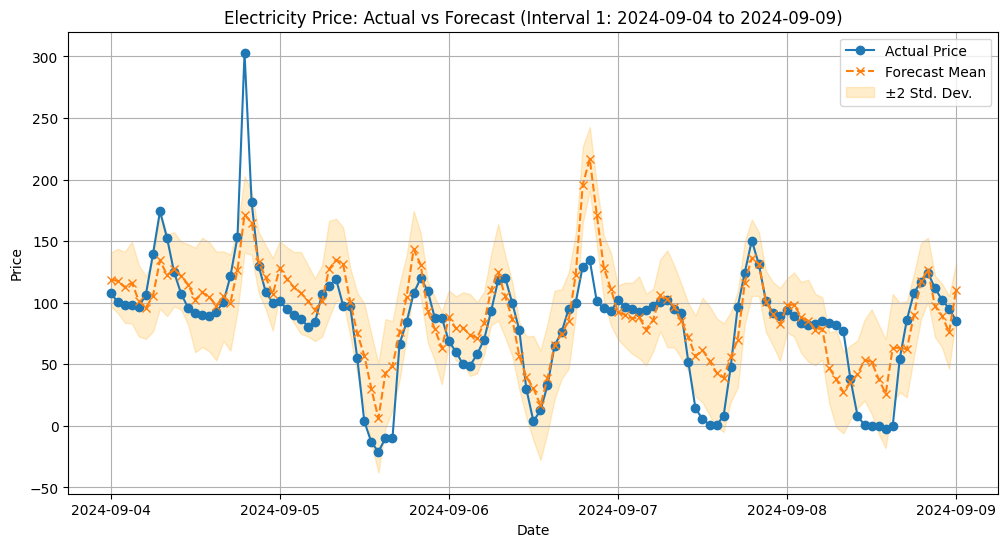

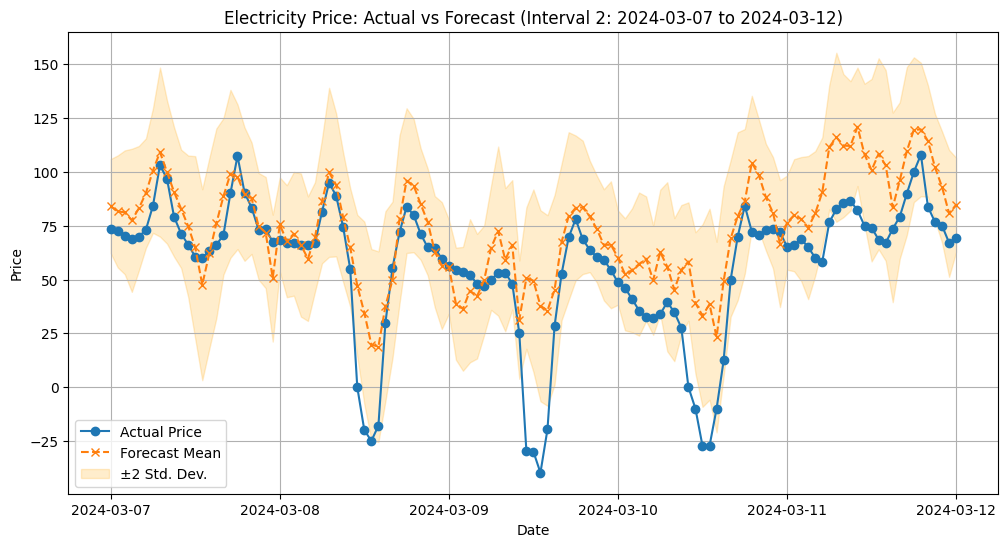

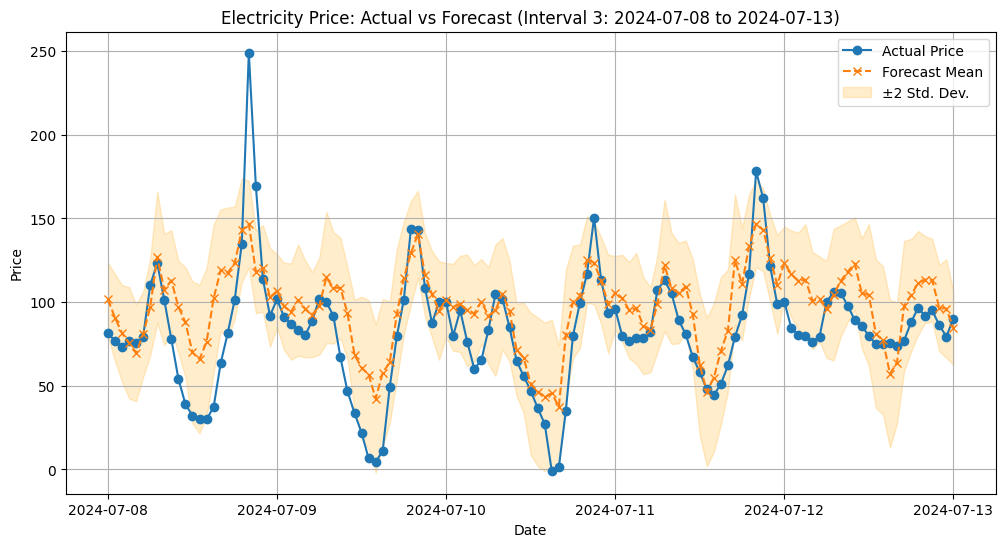

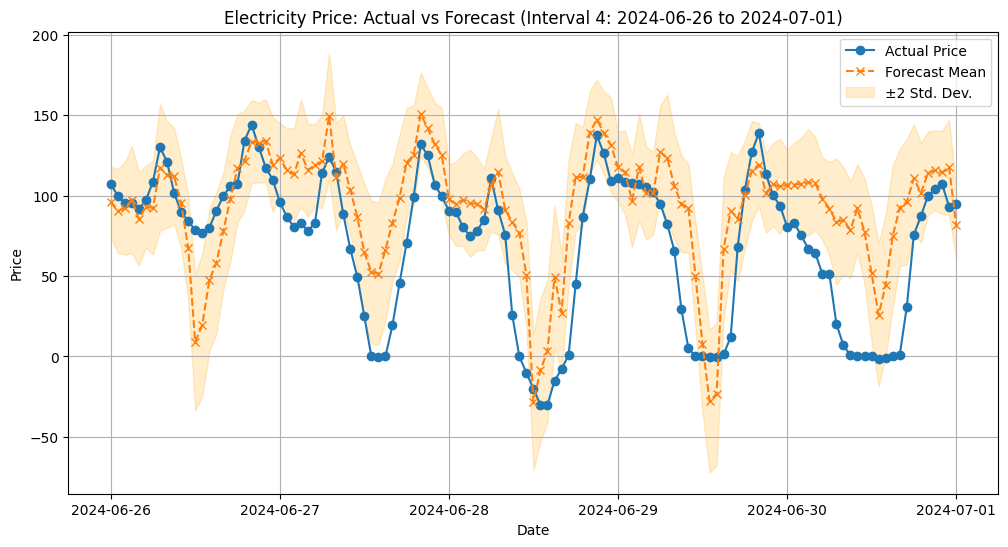

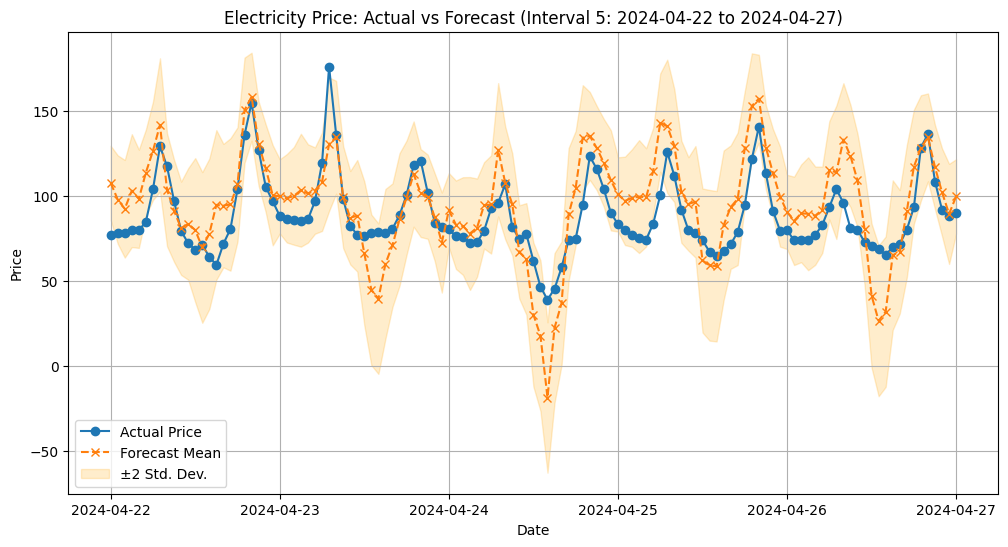

In [50]:
import matplotlib.pyplot as plt
import random

# Filter unique days to only include those after March 1, 2024
start_filter_date = pd.Timestamp("2024-03-01")
filtered_days = [day for day in df.index.normalize().unique() if day > start_filter_date]

# Ensure there are enough days to select 5 intervals
if len(filtered_days) < 5:
    raise ValueError("Not enough days available after March 1, 2024, to plot 5 intervals.")

# Randomly select 5 starting days for the intervals
random_start_days = random.sample(filtered_days[:-5], 5)

# Plot each interval
for i, start_day in enumerate(random_start_days):
    # Define the 5-day interval
    start_plot = start_day
    end_plot = start_plot + pd.Timedelta("5 days")

    # Extract data for the interval
    df_interval = df["Price"].loc[start_plot:end_plot]
    dist_interval = all_predictions.loc[start_plot:end_plot]

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_interval.index, df_interval.values, label="Actual Price", marker='o', linestyle='-')
    plt.plot(dist_interval.index, dist_interval["Forecast"].values, label="Forecast Mean", marker='x', linestyle='--')

    # Add the confidence band (± 2 standard deviations)
    plt.fill_between(dist_interval.index,
                     dist_interval["Forecast"] - 2 * dist_interval["Std"],
                     dist_interval["Forecast"] + 2 * dist_interval["Std"],
                     color='orange', alpha=0.2, label="±2 Std. Dev.")

    # Add title, labels, legend, and grid
    plt.title(f"Electricity Price: Actual vs Forecast (Interval {i + 1}: {start_plot.date()} to {end_plot.date()})")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


In [51]:
from scipy.stats import norm

# Start with all_predictions as distribution_data
distribution_data = all_predictions.copy()

# Ensure the dataframes align:
distribution_data = distribution_data.reindex(df.index)
distribution_data.dropna(subset=["Forecast", "Std"], inplace=True)

# Define the pinball score function
def pinball_score(qhat, x, q):
    """
    Compute the pinball score for a single quantile forecast.
    qhat : predicted quantile value
    x    : observed value
    q    : quantile level (0 < q < 1)
    """
    if x < qhat:
        return (1 - q) * (qhat - x)
    else:
        return q * (x - qhat)

# Set up a grid of quantiles (M quantiles)
M = 99
quantiles = np.linspace(0.01, 0.99, M)

# Compute CRPS for each time point in distribution_data
crps_values = []

print("Computing CRPS for each time point...")
for idx, row in distribution_data.iterrows():
    mu = row["Forecast"]
    sigma = row["Std"]
    # Get the actual price from df
    x = df.at[idx, "Price"]

    # Compute quantile forecasts for each q in quantiles
    qhats = mu + sigma * norm.ppf(quantiles)

    # Compute pinball scores for all quantiles and average
    ps_values = [pinball_score(qhat, x, q) for qhat, q in zip(qhats, quantiles)]
    crps = np.mean(ps_values)  # Approximate CRPS by averaging pinball scores
    
    crps_values.append(crps)

# Add CRPS to distribution_data
distribution_data["CRPS"] = crps_values

import os

output_dir = "model forecasts"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "LEARN-N_forecast_tuned.csv")
distribution_data.to_csv(output_path)

print(f"File saved to: {output_path}")

Computing CRPS for each time point...
File saved to: model forecasts\LEARN-N_forecast_tuned.csv


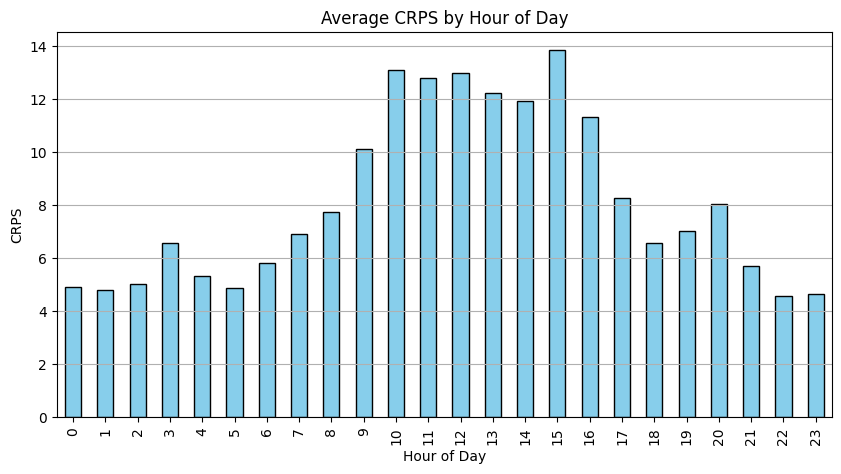

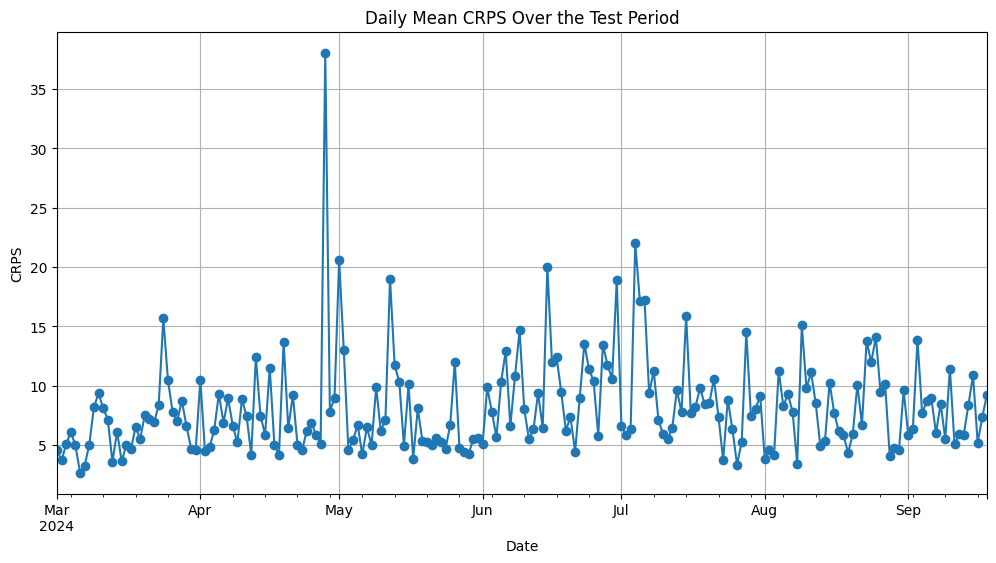

In [52]:
import matplotlib.pyplot as plt

# Ensure that 'distribution_data' has a DateTimeIndex and a "CRPS" column.
# If needed, convert index to datetime:
# distribution_data.index = pd.to_datetime(distribution_data.index)

# 1. Average CRPS by Hour of Day
distribution_data['hour'] = distribution_data.index.hour
hourly_mean_crps = distribution_data.groupby('hour')["CRPS"].mean()

plt.figure(figsize=(10,5))
hourly_mean_crps.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average CRPS by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("CRPS")
plt.grid(axis='y')
plt.show()

# 2. Mean CRPS per Day Over the Test Period
# Extract the date (without time) and compute daily mean CRPS
distribution_data['date'] = distribution_data.index.normalize()
daily_mean_crps = distribution_data.groupby('date')["CRPS"].mean()

plt.figure(figsize=(12,6))
daily_mean_crps.plot(marker='o', linestyle='-')
plt.title("Daily Mean CRPS Over the Test Period")
plt.xlabel("Date")
plt.ylabel("CRPS")
plt.grid(True)
plt.show()

Top 50 features overall:


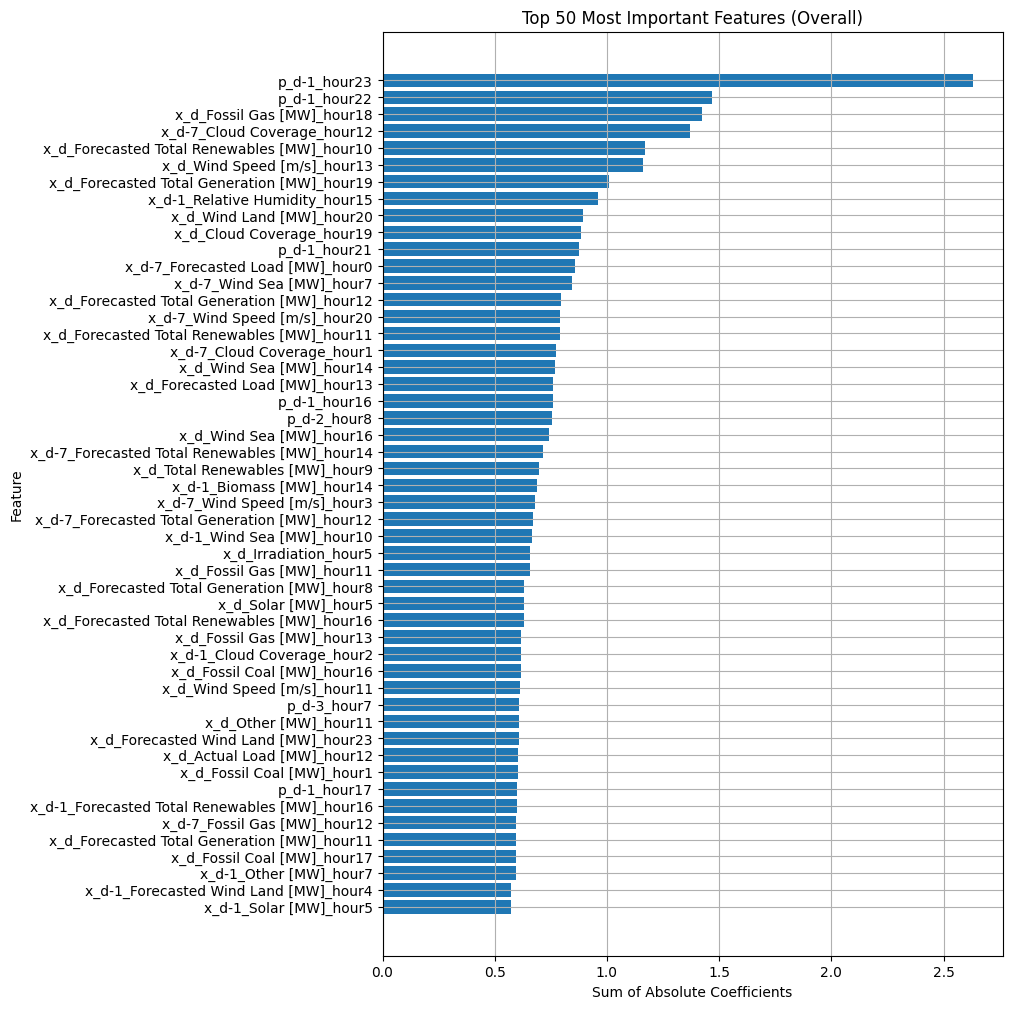

In [53]:
feature_names = []

# Price features: 4 sets of 24 prices
for lag_label in ["p_d-1", "p_d-2", "p_d-3", "p_d-7"]:
    for h in range(24):
        feature_names.append(f"{lag_label}_hour{h}")

# X features: 3 sets of 24-hour x features (e.g., x_d, x_{d-1}, x_{d-7})
# Suppose x_cols are the exogenous variable names. Each day has 24 hours * len(x_cols)
n_x_features = len(x_cols)
for label in ["x_d", "x_d-1", "x_d-7"]:
    for hour_x in range(24):
        for c in x_cols:
            feature_names.append(f"{label}_{c}_hour{hour_x}")

# Day-of-week dummies (7 features)
for day_dummy in day_dummies:
    feature_names.append(day_dummy)


all_abs_coefs = np.zeros(len(feature_names))
for h in range(hours_in_day):
    coefs = models[h].coef_
    all_abs_coefs += np.abs(coefs)

sorted_indices = np.argsort(all_abs_coefs)[::-1]
print("Top 50 features overall:")
for i in range(50):
    idx = sorted_indices[i]
    #print(feature_names[idx], all_abs_coefs[idx])

top_n = 50
idxs = sorted_indices[:top_n]
plt.figure(figsize=(8,12))
plt.barh([feature_names[i] for i in idxs][::-1], all_abs_coefs[idxs][::-1])
plt.title("Top 50 Most Important Features (Overall)")
plt.xlabel("Sum of Absolute Coefficients")
plt.ylabel("Feature")
plt.grid(True)
plt.show()
